In [9]:
import epics

from siriuspy.devices import DVF
from mathphys.imgproc import Image2D_Fit

sizey           : 1024
sizex           : 1280
intensity_min   : 0
intensity_max   : 179
intensity_avg   : 1.6004905700683594
intensity_sum   : 2097795
saturation_val  : 255
saturated       : False
--- fitx ---
size            : 1280
intensity_min   : 1006
intensity_max   : 8784
intensity_avg   : 1638.90234375
intensity_sum   : 2097795
saturation_val  : 255
saturated       : False
roi             : [0, 1280]
roi_center      : 465
roi_fwhm        : 98
roi_amplitude   : 332.9451454251308
roi_mean        : 466.64788131564404
roi_sigma       : 306.9379788890519
roi_fit_err     : 70.53471535903326 %
roi_amplitude   : 332.9451454251308
roi_mean        : 466.64788131564404
roi_sigma       : 306.9379788890519
roi_fit_err     : 70.53471535903326 %
--- fity ---
size            : 1024
intensity_min   : 1204
intensity_max   : 16846
intensity_avg   : 2048.6279296875
intensity_sum   : 2097795
saturation_val  : 255
saturated       : False
roi             : [0, 1024]
roi_center      : 275
roi_fwhm     

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6549b93908>)

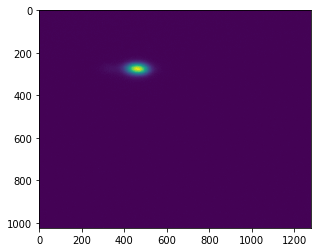

In [16]:
img = Image2D_Fit(data=dvf.image)
print(img)
img.imshow()

In [17]:
roix = [200, 600]
roiy = [200, 400]
img.roi = [roix, roiy]

sizey           : 1024
sizex           : 1280
intensity_min   : 0
intensity_max   : 179
intensity_avg   : 1.6004905700683594
intensity_sum   : 2097795
saturation_val  : 255
saturated       : False
--- fitx ---
size            : 1280
intensity_min   : 1006
intensity_max   : 8784
intensity_avg   : 1638.90234375
intensity_sum   : 2097795
saturation_val  : 255
saturated       : False
roi             : [200, 600]
roi_center      : 465
roi_fwhm        : 98
roi_amplitude   : 2305.3843261902703
roi_mean        : 437.5049031373983
roi_sigma       : 79.21726170997532
roi_fit_err     : 54.11517759891162 %
roi_amplitude   : 2305.3843261902703
roi_mean        : 437.5049031373983
roi_sigma       : 79.21726170997532
roi_fit_err     : 54.11517759891162 %
--- fity ---
size            : 1024
intensity_min   : 1204
intensity_max   : 16846
intensity_avg   : 2048.6279296875
intensity_sum   : 2097795
saturation_val  : 255
saturated       : False
roi             : [200, 400]
roi_center      : 275
roi_fwhm   

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6549ad3940>)

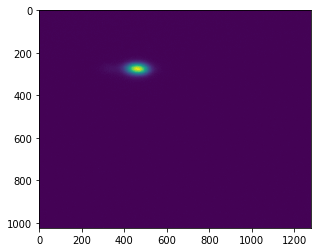

In [18]:
print(img)
img.imshow()

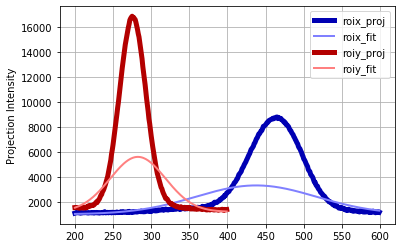

In [19]:
img.plot_projections()

In [20]:
devname = DVF.DEVICES.CAX_DVF2

dvf = DVF(devname)

pv_roix_sp = epics.PV(devname + ':ImgROIX-SP')
pv_roix_rb = epics.PV(devname + ':ImgROIX-RB')
pv_roiy_sp = epics.PV(devname + ':ImgROIY-SP')
pv_roiy_rb = epics.PV(devname + ':ImgROIY-RB')

In [21]:
dvf.wait_for_connection()
dvf.connected
print(pv_roix_sp.connected)
print(pv_roix_rb.connected)
print(pv_roiy_sp.connected)
print(pv_roiy_rb.connected)

True
True
True
True


In [22]:
pv_roix_sp.value = roix
pv_roiy_sp.value = roiy

In [15]:
pv_roix_rb.value

array([ 100, 1280], dtype=int32)

In [4]:
dvf.cmd_acquire_on()

True

In [23]:
from bl_ap_imgproc.imgproc import Measurement

In [26]:
m = Measurement(devname=devname)

In [38]:
cx, cy = m.imgproc.fitx.roi_center, m.imgproc.fity.roi_center 
sx, sy = m.imgproc.fitx.roi_fwhm, m.imgproc.fity.roi_fwhm
f = 1.0
roix = [int(cx - f*sx), int(cx + f*sx)]
roiy = [int(cy - f*sy), int(cy + f*sy)]

In [39]:
m.imgproc.roi = [roix, roiy]

sizey           : 1024
sizex           : 1280
intensity_min   : 0
intensity_max   : 171
intensity_avg   : 1.5453971862792968
intensity_sum   : 2025583
saturation_val  : 255
saturated       : False
--- fitx ---
size            : 1280
intensity_min   : 964
intensity_max   : 8480
intensity_avg   : 1582.48671875
intensity_sum   : 2025583
saturation_val  : 255
saturated       : False
roi             : [356, 552]
roi_center      : 457
roi_fwhm        : 98
roi_amplitude   : 6824.263493031075
roi_mean        : 451.91983394922255
roi_sigma       : 38.84861895743392
roi_fit_err     : 7.337087386951074 %
roi_amplitude   : 6824.263493031075
roi_mean        : 451.91983394922255
roi_sigma       : 38.84861895743392
roi_fit_err     : 7.337087386951074 %
--- fity ---
size            : 1024
intensity_min   : 1132
intensity_max   : 16358
intensity_avg   : 1978.1083984375
intensity_sum   : 2025583
saturation_val  : 255
saturated       : False
roi             : [234, 324]
roi_center      : 276
roi_fwhm    

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f65304cec50>)

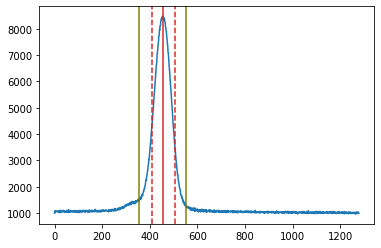

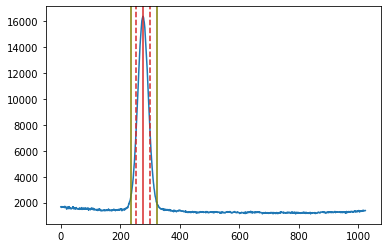

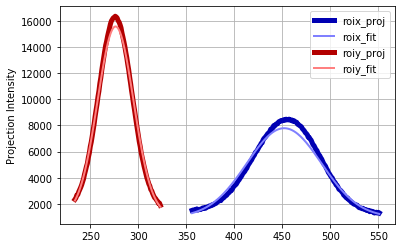

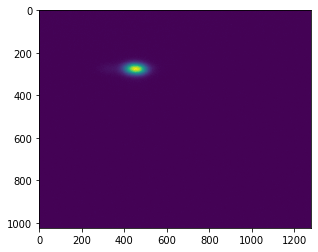

In [41]:
print(m.imgproc)
m.imgproc.fitx.imshow()
m.imgproc.fity.imshow()
m.imgproc.plot_projections()
m.imgproc.imshow()